Kelden Ben-Ora
915987250
EAE 127 Fall 2021

# Project 4 Introduction: Vortex Panel Method

This project's main goal is to explore the characteristics of the vortex panel method as opposed to the previously used souce panel method. First, a few NACA airfoils will be chosen to demonstrate the vortex panel method. The results of the calculated coefficients of pressure and lift are compared to the values generated by xfoil. The first problem will focus on the pressure distribution differences and the next problem will compare the calculated lift over an airfoil. 

## Problem 1: Vortex Panel Method
Three NACA airfoils are analyzed using the vortex panel method in this section. The Aeropython lesson 11 is primarily used for code generation. The functions defined in the Aeropython tutorial are used in the vortex panel method function. The vortex panel method tested here will have its results compared to those acquired by xfoil. The xfoil data was generated separately using a modified version of the pyxfoil_demo.py script that was provided. That script, other accompanying scripts, and the data outputs are found in this folder.

  Airfoil  Cl from Vortex Panel Method  Cl from pyxfoil
0    0020                     0.644731           0.7832
1    2412                     0.696458           0.7148
2    4412                     0.948761           0.6815


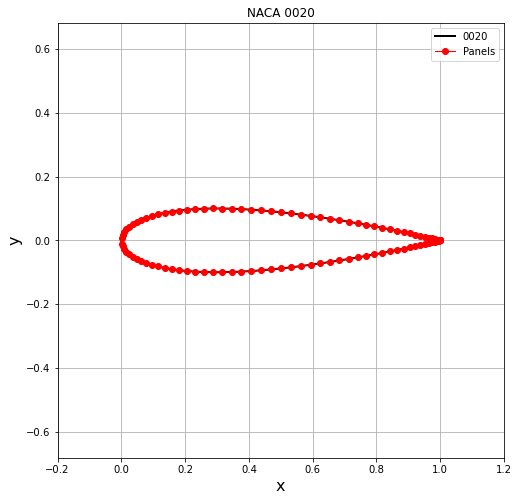

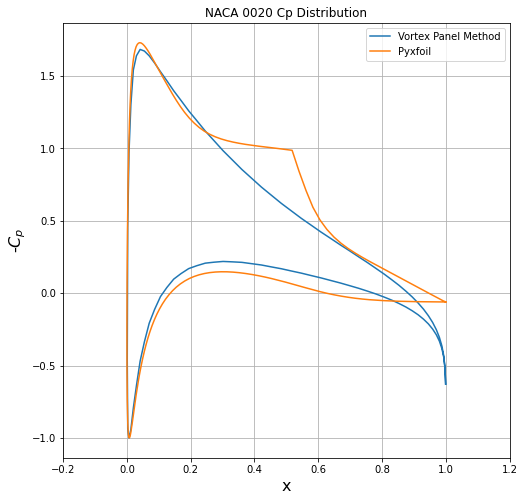

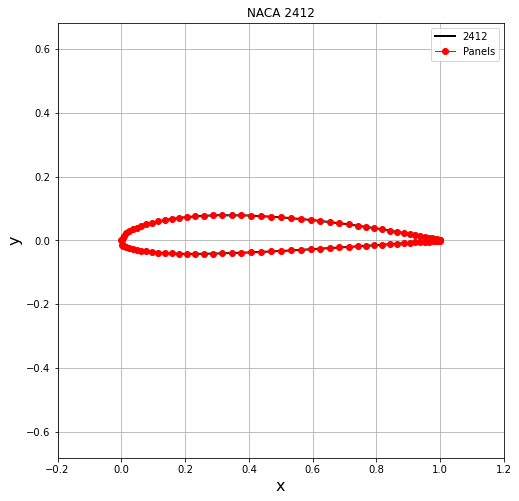

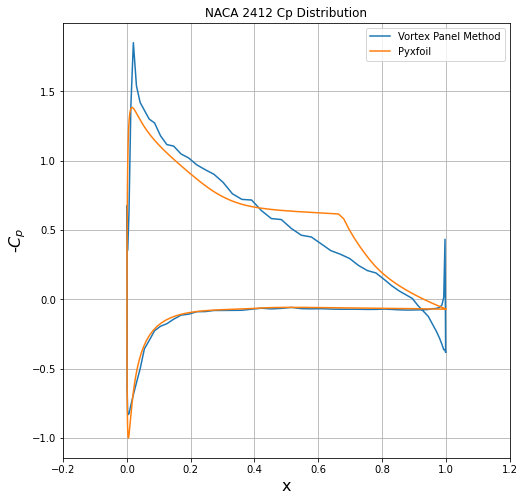

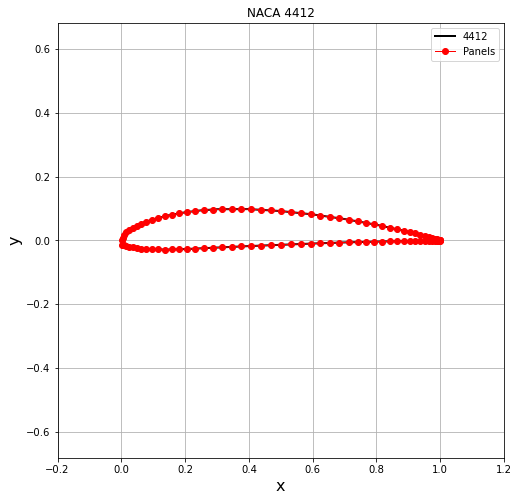

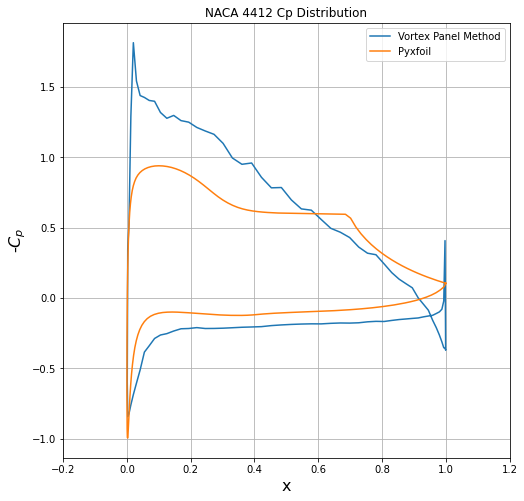

In [61]:
import os
import numpy
import math
import pandas as pd
from scipy import integrate, linalg
from matplotlib import pyplot as plt

%matplotlib inline

# 1a: 3 NACA airfoils - 0020, 2412, 4412
foils = ['0020', '2412', '4412']
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

# discretize geometry into panels
def define_panels(x, y, N):
    stop = len(x)/2
    stop_low = math.floor(stop)
    stop_high = math.ceil(stop)

    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center
    y_center = (y.max() + y.min()) / 2.0  # x-coordinate of circle center
    
    theta = numpy.linspace(0.0, 2.0 * numpy.pi, N+1)  # array of angles
    x_circle = x_center + R * numpy.cos(theta)  # x-coordinates of circle
    y_circle = y_center + R * numpy.sin(theta)  # x-coordinates of circle
    
    x_ends = numpy.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = numpy.empty_like(x_ends)  # y-coordinate of panels end-points

    # extend coordinates to consider closed surface
    #x, y = numpy.append(x, x[0]), numpy.append(y, y[0])

    # compute y-coordinate of end-points by projection
    I = 0

    for i in range(N):
        if i < math.floor(N/2):
            for I in range (stop_low):
                if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                    break
                else:
                    continue
            a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
            b = y[I + 1] - a * x[I + 1]
            y_ends[i] = a * x_ends[i] + b          
        if i > math.ceil(N/2):
            for I in range (len(x) - 2, stop_high, -1):
                if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                    break
                else:
                    continue
            a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
            b = y[I + 1] - a * x[I + 1]
            y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]

    for i in range(N):
        if y_ends[i] > max(y):
            x_ends = numpy.delete(x_ends, i)
            y_ends = numpy.delete(y_ends, i)
            N = len(x_ends) - 1
    
    for i in range(N):
        if y_ends[i] < min(y):
            x_ends = numpy.delete(x_ends, i)
            y_ends = numpy.delete(y_ends, i)
            N = len(x_ends) - 1

    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees to radians

def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex):
    b = numpy.empty(A_source.shape[0] + 1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    A[:-1, :-1] = A_source
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size + 1, dtype=float)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    return b

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size + 1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -numpy.sum(A_source, axis=1)
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2
        

def vortex_method(airfoil, a):
    # load geometry from data file
    naca_filepath = os.path.join('data', f'{airfoil}.dat')
    with open(naca_filepath, 'r') as infile:
        x, y = numpy.loadtxt(infile, dtype=float, unpack=True)

    # make the panels
    panels = define_panels(x, y, 100)
    
    freestream = Freestream(u_inf=10.0, alpha=a)
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
 
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels, freestream)

    # solve for singularity strengths
    strengths = numpy.linalg.solve(A, b)
    # store source strength on each panel
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
    # store circulation density
    gamma = strengths[-1]
    # tangential velocity at each panel center.
    compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    
    # compute the chord and lift coefficient
    c = abs(max(panel.xa for panel in panels) -
            min(panel.xa for panel in panels))
    cl = (gamma * sum(panel.length for panel in panels) /
        (0.5 * freestream.u_inf * c))
    return panels, x, y, cl


cl_list = []
pyxfoil_cl_results = [0.7832, 0.7148, 0.6815]
for i in range(3):
    alpha = 5
    panels, x_panel, y_panel, cl = vortex_method(foils[i], alpha)
    # print(f'Lift coefficient for {foils[i]} from vortex panel method: CL = {cl:0.3f}')
    cl_list.append(cl)
    # plot geometry
    width = 8
    plt.figure(figsize=(width, width))
    plt.grid()
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.plot(x_panel, y_panel, color='k', linestyle='-', linewidth=2, label=f'{foils[i]}')
    plt.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
                numpy.append([panel.ya for panel in panels], panels[0].ya),
                linestyle='-', linewidth=1, marker='o', markersize=6, color='r', label='Panels')
    plt.axis('equal')
    plt.title(f'NACA {foils[i]}')
    plt.xlim(-0.2, 1.2)
    plt.ylim(-0.2, 0.2)
    plt.legend()
    
    cps = []
    xcs = []
    for panel in panels:
        cps.append(-panel.cp)
        xcs.append(panel.xc)
    
    cp_filepath = os.path.join('data', f'naca{foils[i]}', f'naca{foils[i]}_surfCP_Re5.00e+04a5.0.dat')
    with open(cp_filepath, 'r') as file_name:
        x_pyxfoil, y_pyxfoil, c_pyxfoil = numpy.loadtxt(file_name,unpack=True, skiprows=3)
        
    
    plt.figure(figsize=(width, width))
    plt.plot(xcs, cps, label='Vortex Panel Method')
    plt.plot(x_pyxfoil, -c_pyxfoil, label='Pyxfoil')
    plt.grid()
    plt.xlabel('x', fontsize=16)
    plt.ylabel(r'-$C_p$', fontsize=16)
    plt.xlim(-0.2, 1.2)
    plt.title(f'NACA {foils[i]} Cp Distribution')
    plt.legend()
    
d = {'Airfoil': foils, 'Cl from Vortex Panel Method': cl_list, 'Cl from pyxfoil': pyxfoil_cl_results}
print(pd.DataFrame(d))

The results of these graphs are fascinating. The results from pyxfoil using viscous effects with a Reynold's number of 5e4 leads to a noticeably different distribution of the coefficient of pressure. There is a sharp bend on the top surface indicating the point at which the boundary layer is separating from the surface. The aft side of this sharp dip indicates a large adverse pressure gradient which leads to the boundary surface separation. The location of the boundary separation differs between the airfoils as well. Those with camber exhibit a flow separation much further aft than the symmetric airfoil. It is also interesting to note the differences in the maximum suction point between the pyxfoil and vortex method results and between airfoils. The graphs indicate that as the camber increases, the maximum suction decreases on the leading edge.

There are obvious differences in the Cl results as well between the pyxfoil and the vortex panel method. These differences are outlined in the table located above the graphs. In the second part of this problem, a convergence of these coefficients of lift is attempted by slowly increasing the Reynold's number. The increase in Reynold's number transitions the flow into the turbulent region. A turbulent boundary layer will increase the drag on the surface of the airfoil.

The coefficient of lift convergence was run using the project4-1.py script to iterate on the pyxfoil results until a Reynold's number was reached that yielded a coefficient of lift relatively very close to the coefficient of lift calculated from the vortex panel method. The table displayed below summarizes the coefficients of lift for each of the three airfoils calculated from the vortex panel method and from pyxfoil. The associated Reynold's number required for convergence is included. It is important to remember that the vortex panel method from above does not take the Reynold's number and viscous effects into account. Only the pyxfoil script calculates coefficients of lift while accounting for viscous effects.

In [62]:
Re_list = [1.4e5, 4.75e4, 7.75e4]
pyxfoil_cl_results = [0.6454, 0.6999, 0.9485]
d = {'Airfoil': foils, "Reynold's number": Re_list, 'Cl from Vortex Panel Method': cl_list, 'Cl from pyxfoil': pyxfoil_cl_results}
print(pd.DataFrame(d))

  Airfoil  Reynold's number  Cl from Vortex Panel Method  Cl from pyxfoil
0    0020          140000.0                     0.644731           0.6454
1    2412           47500.0                     0.696458           0.6999
2    4412           77500.0                     0.948761           0.9485


What is peculiar about these results is that I had to decrement the Reynold's number by 2500 on the 2412 airfoil to get the coefficients of lift to converge. The others required incremenets in the Reynold's number to reach convergence of coefficients of lift. All of the airfoils exhibited an asymptotic tendency in the coefficient of lift as the Reynold's number was increased. Below is a summary of the coefficients of lift that each airfoil converged to as the Reynold's number was increased. Increasing the Reynold's number had little or no effect on the coefficients once they reached these values.

In [63]:
Re_list = [2.75e5, 8.25e4, 1e5]
converged_cl = [0.51, 0.8, 1]
d = {'Airfoil': foils, "Reynold's number": Re_list, 'Converged Cl': converged_cl}
print(pd.DataFrame(d))

  Airfoil  Reynold's number  Converged Cl
0    0020          275000.0          0.51
1    2412           82500.0          0.80
2    4412          100000.0          1.00


High Reynold's numbers indicate that the flow becomes turbulent. The calculations change because the viscous effects change as the boundary layer becomes more turbulent and is more prone to separating from the surface.

## Problem 2: Lift Curve
In this problem, the lift curve (Cl vs alpha) is generated for the 4408 and 4520 airfoils. The lift curves are generated using both the vortex panel method script from above and pyxfoil to compare the results. The two methods are run through alphas of 0 to 30 to generate smooth plots of the coefficients of lift. The two methods calculate the flows differently so we expect to see differing results. The pyxfoil scripts used to generate the data was run separately. That script, its accompanying dependencies, and the data outputs are located in this folder.

The vortex panel method is used to calculate the coefficients of lift with only the inviscid assumption. The pyxfoil method is used to calculate the coefficients of lift with viscous effects. Viscous effects typically make a big difference in the values for the coefficients of lift and drag. This is why the results of one method differ so greatly from the other in the following graphs.

The 4408 airfoil was a given requirement. The 4408 airfoil did not generate Cl values for alphas past 16 in the pyxfoil script with viscous effects. This is why the pyxfoil line in the following graph for 4408 is truncated. The 4520 airfoil was chosen somewhat arbitrarily. When attempting to generate data for other similar airfoils like 4208, the pyxfoil script was unable to calculate Cl values for all alpha values from 0 to 30. The limiting alpha ranged from about 14 to 28 depending on the airfoil that was chosen. I hypothesized that pyxfoil was not able to calculate well in the post-stall region so I tried using airfoils that would have very benign smooth post-stall characteristics. This theory worked. The 4520 airfoil managed to generate data for alphas 0 to 30 luckily which is how it was chosen as the second airfoil for this problem.

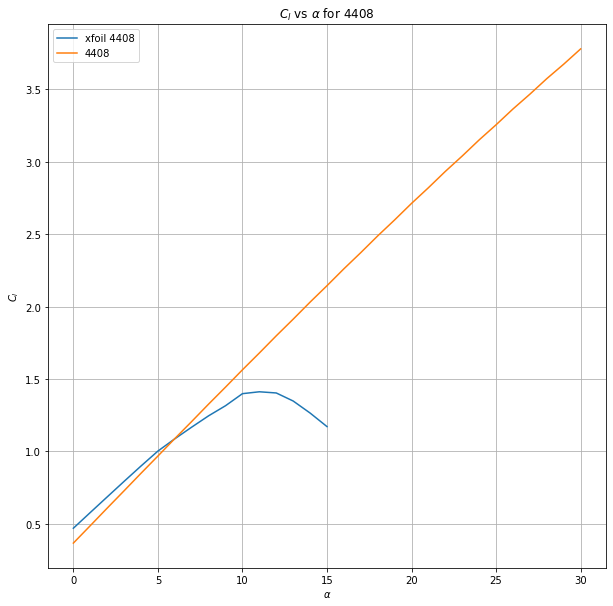

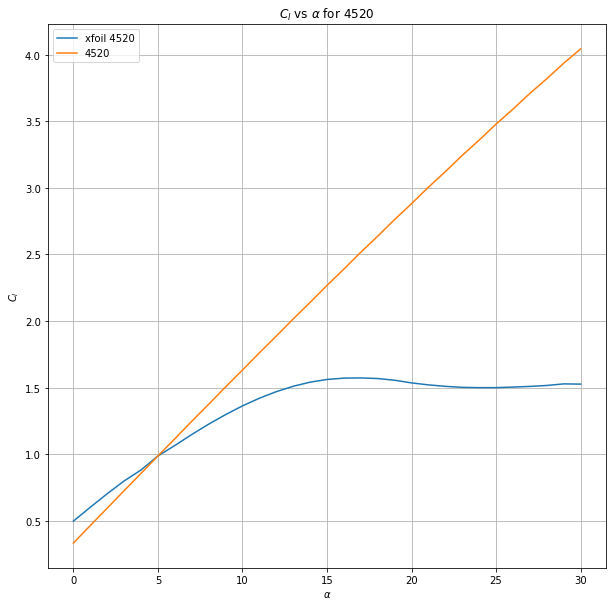

In [36]:
# Calculating coefficients of lift for alpha 0-30 with no viscous effects in vortex panel method
foils = ['4408', '4520']
alphas = numpy.linspace(start=0, stop=30, num=31)

# the following viscous cl data was generated separately using the modified pyxfoil_demo.py and project4-2.py scripts
pyxfoil_cl_4408 = [0.4697, 0.5781, 0.6858, 0.7932, 0.8993, 1.0025, 1.0873, 1.1679, 1.2462, 1.3158, 1.399, 1.412, 1.4038 , 1.3482 , 1.2652 , 1.1715]
pyxfoil_cl_4520 = [0.4977, 0.6017, 0.7034, 0.7990, 0.8817, 0.9868, 1.0655, 1.1477, 1.2255, 1.2972, 1.3628, 1.4204, 1.4696, 1.5101, 1.5409, 1.5612, 1.5713, 1.5726, 1.5682, 1.5554, 1.5354, 1.5205, 1.5095, 1.5019, 1.4997, 1.4999, 1.5041, 1.5091, 1.5161, 1.528, 1.5262]

for i in range(2):
    cl_list = []
    # repeat for each airfoil
    for j in range(len(alphas)):
        # repeat for each alpha 0-30
        panels, x, y, cl = vortex_method(foils[i], alphas[j])
        cl_list.append(cl)
    plt.figure(figsize=(10, 10))
    if i < 1:
        plt.title(r'$C_l$ vs $\alpha$ for 4408')
        plt.plot(pyxfoil_cl_4408, label='xfoil: 4408')
    else:
        plt.title(r'$C_l$ vs $\alpha$ for 4520')
        plt.plot(pyxfoil_cl_4520, label='xfoil: 4520')
    plt.plot(alphas, cl_list, label=f'Vortex method: {foils[i]}')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$C_l$')
    plt.grid()
    plt.legend()
    plt.show()            
    



The above graphs show that the viscous effects are primarily what cause the airfoils to reach their critical angle of attack. The vortex panel method without the viscous effects has a steeper Cl vs alpha slope and it does not exhibit any stall characteristics. With the viscous effects, the boundary layer is more realistic and the boundary layer separation can be modeled. The boundary layer separation results in the stall and the effective decrease in the coefficient of lift after the critical angle of attack.

## Problem 3: Additional Problems

Airfoils are a broadly used geometry for many applications besides airplanes. Their basic purpose is to create a difference in pressure in a fluid and a resulting force.

### Problem 3.1: Airfoil Selection
There are many fascinating and important airfoils out there. I have no favorite airfoil but for this problem I have chosen the Wortmann FX S 02-196 airfoil. It is the airfoil used on the Schleicher ASK 21 sailplane. It is plotted below. It is characterized by a large maximum thickness and a maximum thickness that occurs far aft on the airfoil. It has very benign stall characteristics and provides huge amounts of lift. It allows the sailplane to achieve a glide ratio of approximately 34. This results in about 1000 feet of altitude lost per 5 miles traveled. 

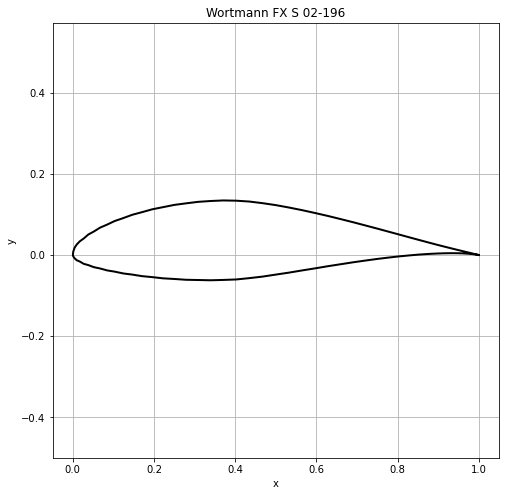

In [ ]:
foil_path = os.path.join('data', 'fxs02196.dat')

with open(foil_path, 'r') as file_name:
    x, y=numpy.loadtxt(file_name,unpack=True)
plt.figure(figsize=(8, 8))
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Wortmann FX S 02-196')
plt.axis('equal')
plt.show()

### Problem 3.2: Airfoil Uses
Airfoils can be used for power generation in turbines and on racecars besides several other possible uses. For power generation, steam is typically pushed through many layers of airfoils in a turbine resulting in rotational forces being exerted on a shaft. The airfoils are oriented so that they generate lift tangentially to the cylindrical surface that they are attached to. That rotational force can then be transformed to other types of energy such as electrical energy to power homes. Vehicles such as racecars and motorcycles often make use of airfoils to push the vehicle down against the ground harder so that the normal force and friction are increased. With extremely powerful engines, the vehicles need this increased frictional force so that the wheels do not slip against the surface. As the vehicle moves faster through the air, the airfoils create more lift in the downward direction.

# Project 4 Conclusion
In this project, I learned about the vortex panel method in regards to calculating a coefficient of pressure distribution and the coefficient of lift for various airfoils. In problem 1, I was surprised to see that even though we neglected viscous effects in the vortex panel method, we were able to find Reynold's numbers for the pyxfoil script that takes viscous effects into account which led to coefficients of lift that matched the results of the vortex panel method. It was also very interesting to see the differences in the distributions of the coefficient of pressure when including viscous effects. The distributions were very different from those obtained with no visous effects which makes sense because the viscosity leads to all the interesting characteristics of the boundary layer behaviors. 

In problem 2, I got to see how the viscous effects are really to blame for stalling. With no viscous effects, the coefficient of lift just keeps increasing with alpha but with the viscous effects, the slope is a bit shallower and there is a clear reduction of lift at a critical angle of attack. It is strange to see that the coefficient of lift would continue straight for so long with no viscous effects. It was fun to see the different stall characteristics of the airfoils also since the 4408 had a typical stall while the 4520 shows a very shallow and benign post-stall region. 